## Install mplcairo backend first

```bash
pip install numpy pandas matplotlib pycairo Pillow
pip install git+https://github.com/anntzer/mplcairo
```


## Import modules, set plot styles & some color functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import mplcairo
mpl.use("module://mplcairo.base")
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

# use floating point surfaces for lines with tiny alpha values
mplcairo.set_options(float_surface=True)

# use best antialiasing
# https://github.com/matplotlib/mplcairo?tab=readme-ov-file#antialiasing
from mplcairo import antialias_t
dict.__setitem__(plt.rcParams, "lines.antialiased", antialias_t.BEST)
dict.__setitem__(plt.rcParams, "patch.antialiased", antialias_t.BEST)
dict.__setitem__(plt.rcParams, "text.antialiased", antialias_t.GRAY)

# general theme
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [2]:
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

def img2cmap(fname, name=None, reversed=False):
    cmap_arr = np.array(Image.open(fname))[0].astype(np.float64) / 255.0
    return LinearSegmentedColormap.from_list(
        (name or fname) + ('_r' if reversed else ''),
        np.flip(cmap_arr, 0) if reversed else cmap_arr
    )

def get_color(cmap, val, alpha):
    color = cmap(val)
    color = list(color)
    if len(color) == 4:
        color[3] = alpha
    elif len(color) == 3:
        color.append(alpha)
    else:
        raise ValurError(color)
    return tuple(color)


## Load prediction result and prepare data

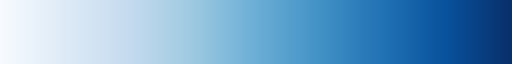

In [3]:
plot_df = pd.read_csv('All_Comb_Prediction.csv')#.sample(n=100, ignore_index=True)
plot_df['Relative_Standard_Deviation'] = np.clip(plot_df['Fold_Increase_STD'] / plot_df['Fold_Increase'], 0, 1)

######### For Fold Increase #########
Y_COL = 'Fold_Increase'
Y_MIN, Y_MAX = 0, 30
higher_is_better = True
sorting_randomness = 0.7

# Generating colormap
cmap = img2cmap('Blue.png', 'custom_coolwarm', reversed=not higher_is_better)
display(cmap)

rng = np.random.default_rng(0)
plot_df = plot_df.sort_values(Y_COL, ignore_index=True, 
                              ascending=higher_is_better, 
                              key=lambda s: s + rng.random(size=s.shape) * (Y_MAX - Y_MIN) * sorting_randomness)

y_cols = [
    'Day1_H2O2', 'Day2_H2O2','Day3_H2O2',
    'Day1_Lysozyme', 'Day2_Lysozyme','Day3_Lysozyme',
    'Day1_Sonication', 'Day2_Sonication', 'Day3_Sonication',
    Y_COL
]
y_names = [y.replace('_', '\n').replace('Day', 'Day ').replace('H2O2', '$H_2O_2$') for y in y_cols]

y_ticks = [{
    'H2O2': [0, 10, 25, 50],
    'Lysozyme': [0, 0.75, 1.5, 2.25, 3.0],
    'Sonication': [0, 20, 30, 60],
    'Increase': np.linspace(Y_MIN, Y_MAX, 4),
    'Standard': np.linspace(Y_MIN, Y_MAX, 5),
}[y.split('_')[1]] for y in y_cols]

line_values = plot_df[Y_COL].values / Y_MAX
line_alphas = np.clip(line_values, 0, 1)
if Y_COL == 'Fold_Increase':
    # There are lots of lines where Fold_Increase is 15.0 (= Y_MAX / 2), 
    # so we curve the line alphas to let lines with Fold_Increase close to Y_MAX/2 have alpha values close to 0
    line_alphas = (np.abs((line_alphas - 0.5) * 2) ** 4) * 0.9 + 0.006
elif Y_COL == 'Relative_Standard_Deviation':
    line_alphas = ((1.5 - np.clip(line_alphas, 0.1, 0.9)) ** 4) * 0.2 + 0.01
else:
    print('line_alphas transform skipped')

y_values = plot_df[y_cols].values
rng = np.random.default_rng(0)

# Add noise to Day1 ~ Day3 process volumns to randomly shift lines around ticks
SHIFT_BAND_WIDTH = 0.3
norm_y_values = OrdinalEncoder().fit_transform(y_values[:,:-1]) + rng.uniform(low=-SHIFT_BAND_WIDTH, high=SHIFT_BAND_WIDTH, size=y_values[:,:-1].shape)
norm_y_values = np.hstack((norm_y_values, y_values[:,-1:]))


## Parallel Coordinates Plot 

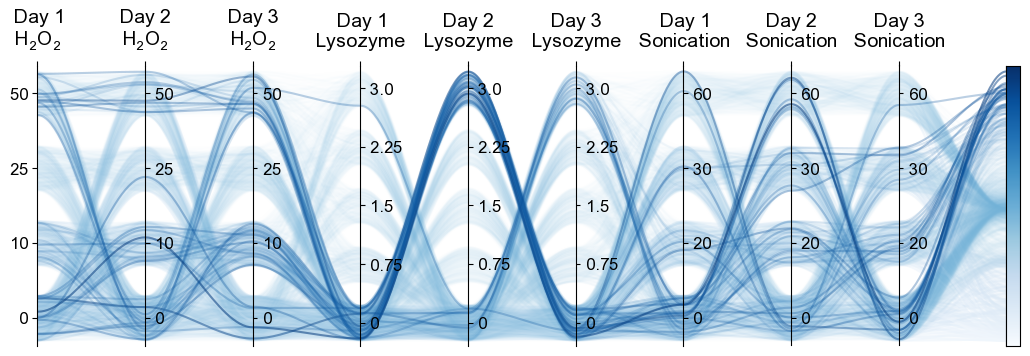

In [4]:
from matplotlib.path import Path
import matplotlib.patches as patches

y_mins, y_maxs = norm_y_values.min(axis=0), norm_y_values.max(axis=0)
y_deltas = y_maxs - y_mins
y_mins -= y_deltas * 0.02
y_maxs += y_deltas * 0.02
y_deltas = y_maxs - y_mins

# transform all data to be compatible with the main axis
z_values = np.zeros_like(norm_y_values)
z_values[:, 0] = norm_y_values[:, 0]
z_values[:, 1:] = (norm_y_values[:, 1:] - y_mins[1:]) / y_deltas[1:] * y_deltas[0] + y_mins[0]

plt.close('all')
fig, host = plt.subplots(figsize=(12, 4), gridspec_kw=dict(left=0.1, right=0.95, bottom=0.1, top=0.8))

axes = [host] + [host.twinx() for i in range(norm_y_values.shape[1]-1)]

for i, ax in enumerate(axes):
    ax.set_ylim(y_mins[i], y_maxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    if i == (len(axes) - 1):
        ax.set_yticks([])
        ax.set_ylim(Y_MIN, Y_MAX)
    else:
        ax.set_yticks(list(range(len(y_ticks[i]))), labels=list(map(str, y_ticks[i])))
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (y_values.shape[1] - 1)))
    ax.tick_params(axis='y', which='major', labelsize=12)

host.set_xlim(0, y_values.shape[1] - 1)
host.set_xticks(range(y_values.shape[1] - 1))
host.set_xticklabels(y_names[:-1], fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()

cbar = plt.colorbar(
    mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=Y_MIN, vmax=Y_MAX), cmap),
    ax=axes[-1], pad=0, shrink=1, fraction=0.05
)
# cbar.ax.set_ylabel(y_names[-1].replace('\n', ' '), fontsize=14, labelpad=10)
# cbar.ax.tick_params(axis='y', which='major', labelsize=12)
cbar.set_ticks([])  # removes the ticks
cbar.set_ticklabels([])  # removes the tick labels
cbar.set_label('')  # removes the axis label


for j in range(norm_y_values.shape[0]):
    # create bezier curves
    verts = list(zip([x for x in np.linspace(0, len(y_values) - 1, len(y_values) * 3 - 2, endpoint=True)],
                     np.repeat(z_values[j, :], 3)[1:-1]))
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', 
                              lw=1.5, 
                              edgecolor=get_color(cmap, line_values[j], line_alphas[j]), )
    host.add_patch(patch)

fig.savefig(f'FlowGraph.{Y_COL}_og.png', dpi=300, transparent=True)
fig